# Heuristic LV Segmentation
Two heuristic approaches are investigated in this notebook: simple thresholding and active contour.

Simple thresholding only uses intensity information to determine if a pixel is in foreground or background. Active contour, on the other hand, leverages both intensity information and smoothness of the edge to segment foreground from background. Data suggest that both methods fail to achieve an ideal performance. Both methods produces a 83%-84% True Positive Rate (TPR) while having a 28% False Positive Rate (FPR). The TPR is mediocre and the FPR is too high.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['font.size'] = 18

## Data Preparation
To prepare the data, I use the parser I wrote to ingest the data folder and filter out all the records that have all DICOM, i-contour, and o-contour images. This is easily done as follows.

In [2]:
from dicom_contour_parser import DicomContourParser
parser = DicomContourParser('final_data/')
records = [r for r in parser.record_list if r.has_dicom() and r.has_icontour()
           and r.has_ocontour()]
print('{:d} records in total were found.'.format(len(records)))

46 records in total were found.


## Simple Thresholding
To be able to segment a region reliably using simple thresholding, the pixel values of the foreground and background should have a significant statistical difference. To check that, I plot the histogram of pixel values within the blood pool and within the muscle.

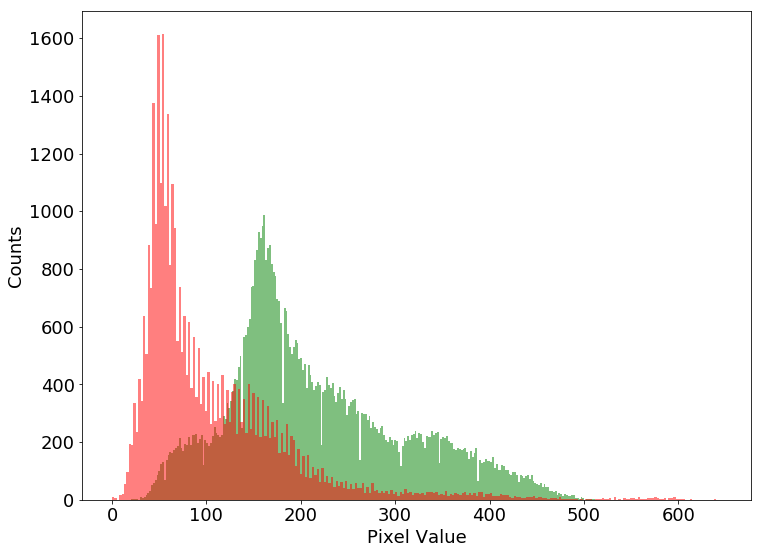

In [3]:
# Walk through all filtered records and collect pixel values of both regions
blood_pixels = []
muscle_pixels = []
for r in records:
    img, ic, oc = r.data.dicom, r.data.ic_mask, r.data.oc_mask
    blood_mask = ic
    # muscle is within oc but not in ic
    muscle_mask = np.logical_and(oc, np.logical_not(ic))
    blood_pixels.extend(list(img[blood_mask]))
    muscle_pixels.extend(list(img[muscle_mask]))
fig, ax = plt.subplots(1, 1, figsize=(12, 9))
ax.hist(np.array(blood_pixels), bins=256, alpha=0.5, fc='g')
ax.hist(np.array(muscle_pixels), bins=256, alpha=0.5, fc='r')
ax.set_xlabel('Pixel Value')
ax.set_ylabel('Counts')

Given the significant overlap of the two pixel populations, I would speculate that a simple thresholding scheme would not work. To further demonstrate that, we can plot the ROC curve of the simple thresholding scheme. Note that I treat *blood pool as positiv* and *heart muscle as negative*.

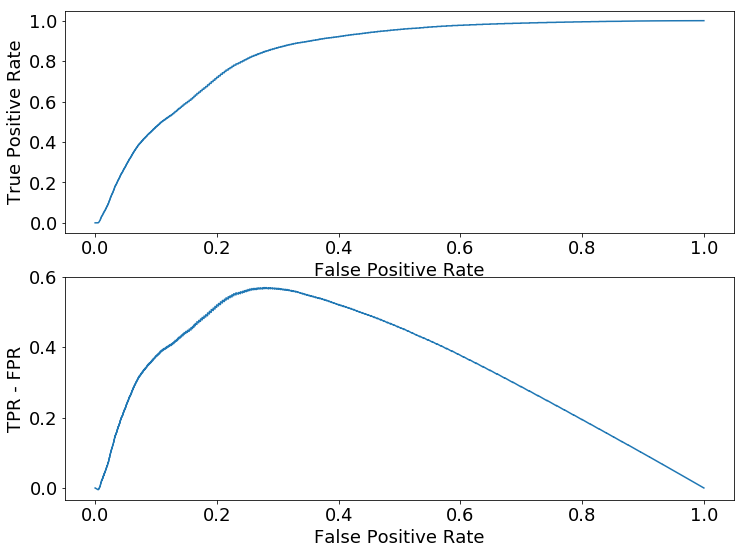

In [4]:
TPR = [1.0]
FPR = [1.0]
blood_pixels.sort()
muscle_pixels.sort()
cond_pos = len(blood_pixels)
cond_neg = len(muscle_pixels)
false_pos = cond_neg
false_neg = 0
for v in muscle_pixels:
    false_pos -= 1
    while false_neg < cond_pos and blood_pixels[false_neg] <= v:
        false_neg += 1
    TPR.append(1.0 - false_neg/cond_pos)
    FPR.append(false_pos/cond_neg)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(FPR, TPR)
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('TPR - FPR')
ax2.plot(FPR, [t-f for f, t in zip(FPR, TPR)])

The ROC curve (top panel) is not as ideal as one may hope. And if we try to build a naive Baysian binary classifier based on just pixel values (see bottom panel), the max. TPR - FPR (in other words, min. Type I error + Type II error) can only reach 0.56, where we still have ~0.28 FPR with a mediocre ~0.84 TPR.

## Active Contour
One of the other popular heuristic segmentation methods are the active contour method. As skimage's active contour demo page puts it: "The active contour model is a method to fit open or closed splines to lines or edges in an image. It works by minimising an energy that is in part defined by the image and part by the spline’s shape: length and smoothness."

This method has a seemingly better opportunity to succeed because it leverage not just intensity information, but also the intrinsic features of the contour shape, which may be important to segmentation.

First, I'd like to try a concrete example. I randomly pick an image from all records, and try to use the active contour model to fit the i-contour from the o-contour.

[]

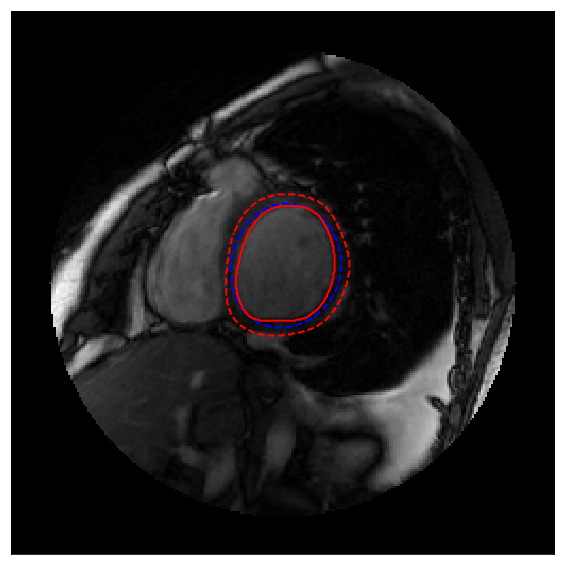

In [5]:
from skimage.filters import gaussian
from skimage.segmentation import active_contour
def ac_snake(img, ocm, ocp):
    return active_contour(img*ocm, ocp, alpha=0.75, beta=0.1, gamma=0.1)
# pick the 10-th record as an example
img, _, ocm, icp, ocp = records[10].data
icp = np.array(icp)
ocp = np.array(ocp)
snake = ac_snake(img, ocm, ocp)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(img, cmap='gray')
ax.plot(ocp[:, 0], ocp[:, 1], '--r', lw=2)
ax.plot(snake[:, 0], snake[:, 1], '--b', lw=2)
ax.plot(icp[:, 0], icp[:, 1], '-r', lw=2)
ax.set_xticks([])
ax.set_yticks([])

Based on this one particular sample, the result looks promising. Notice that the red, dashed curve is the outer contour; the red, solid curve is the inner contour; and the blue, dashed curve is the predicted segmentation obtained by the active contour model.

The next step is to validate that this method also makes sense on a statistical level.

In [6]:
from dicom_contour_parser.parsing import poly_to_mask
total_cond_pos = 0
total_cond_neg = 0
total_false_pos = 0
total_false_neg = 0
for i, r in enumerate(records):
    img, icm, ocm, _, ocp = r.data
    ocp = np.array(ocp)
    acp = ac_snake(img, ocm, ocp)
    acp = [tuple(row) for row in list(acp)]
    acm = poly_to_mask(acp, img.shape[1], img.shape[0])
    cond_pos = np.sum(icm)
    cond_neg = np.sum(np.logical_and(ocm, np.logical_not(icm)))
    false_pos = np.sum(np.logical_and(acm, np.logical_not(icm)))
    false_neg = np.sum(np.logical_and(icm, np.logical_not(acm)))
    total_cond_pos += cond_pos
    total_cond_neg += cond_neg
    total_false_pos += false_pos
    total_false_neg += false_neg
    # print('{:02d}, {:s}-{:04d}: False positive rate = {:.2f}, False negative rate = {:.2f}'
    #       .format(i, r.patient_id, r.serial_id, false_pos/cond_neg, false_neg/cond_pos))
print('Overal: False positive rate = {:.2f}, False negative rate = {:.2f}'.format(
total_false_pos/total_cond_neg, total_false_neg/total_cond_pos))

Overal: False positive rate = 0.27, False negative rate = 0.17


Although conceptually more appealing, the data, however, suggest that the active contour model does not provide statistically better results than simple thresholding, as a similar FPR and FNR/TPR relation is observed.